<a href="https://colab.research.google.com/github/taba4ek555/Diplom/blob/main/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Добавляем гугл диск в гугл колаб с готовым датасетом
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.0 MB/s eta 0:00:00


In [ ]:
#Распаковываем архив с датасетом
!unzip /content/drive/MyDrive/LFW-FER.zip -d ./


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./LFW-FER/train/neutral/Nanni_Moretti_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Nanni_Moretti_0002.jpg  
  inflating: ./LFW-FER/train/neutral/Hushiar_Zebari_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Hushiar_Zebari_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Allen_Rock_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Allen_Rock_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Keith_Bogans_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Keith_Bogans_0002.jpg  
  inflating: ./LFW-FER/train/neutral/John_Kerry_0017.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._John_Kerry_0017.jpg  
  inflating: ./LFW-FER/train/neutral/Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Eric_Rosser_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/

In [ ]:
#Импортирование библиотек
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import metrics
import cv2
from sklearn.utils.class_weight import compute_class_weight
import mediapipe as mp
import math

In [ ]:
#Создал функцию для нормализации координат
def norm_coordinates(normalized_x, normalized_y, image_width, image_height):

    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)

    return x_px, y_px

def get_box(fl, w, h):
    idx_to_coors = {}
    for idx, landmark in enumerate(fl.landmark):
        landmark_px = norm_coordinates(landmark.x, landmark.y, w, h)

        if landmark_px:
            idx_to_coors[idx] = landmark_px

    x_min = np.min(np.asarray(list(idx_to_coors.values()))[:,0])
    y_min = np.min(np.asarray(list(idx_to_coors.values()))[:,1])
    endX = np.max(np.asarray(list(idx_to_coors.values()))[:,0])
    endY = np.max(np.asarray(list(idx_to_coors.values()))[:,1])

    (startX, startY) = (max(0, x_min), max(0, y_min))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

    return startX, startY, endX, endY

edited_train = []
edited_test = []

In [ ]:
#Функция для выделения и масштабирования лица
def prepare(image):
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:
        results = face_mesh.process(image)
        if not results.multi_face_landmarks:
            raise ValueError()
        for fl in results.multi_face_landmarks:
            startX, startY, endX, endY  = get_box(fl, image.shape[1], image.shape[0])
            face = image[startY:endY, startX: endX]
            return cv2.resize(face, (250, 250), interpolation=cv2.INTER_LANCZOS4)

In [ ]:
#Создаём словари для кодирования эмоций и списки для хранения данных
numbers_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
names_numbers = {'negative': 0, 'neutral': 1, 'positive': 2}
train_images = []
train_labels = []
test_images = []
test_labels = []

Загрузка изображений


In [ ]:
folders = [folder for folder in os.listdir('/content/LFW-FER/train')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'/content/LFW-FER/train/{folder}'):
        image = Image.open(f'/content/LFW-FER/train/{folder}/{image_path}')
        try:
            image = Image.fromarray(prepare(np.array(image)))
        except ValueError:
            continue
        train_images.append(np.array(image))
        train_labels.append(names_numbers[folder])
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
folders = [folder for folder in os.listdir('/content/LFW-FER/eval')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'/content/LFW-FER/eval/{folder}'):
        image = Image.open(f'/content/LFW-FER/eval/{folder}/{image_path}')
        try:
            image = Image.fromarray(prepare(np.array(image)))
        except ValueError:
            continue
        test_images.append(np.array(image))
        test_labels.append(names_numbers[folder])
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
len(train_images), len(test_images)

(9329, 1157)

Пример изображений


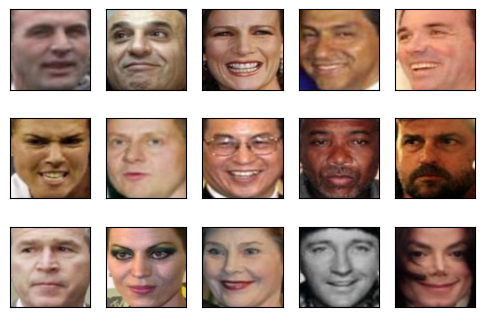

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(6, 4))
for i in range(15):
    ax = axs[i // 5, i % 5]
    ax.imshow(train_images[random.randint(0, len(train_images))])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 768, 3359, 5202]))

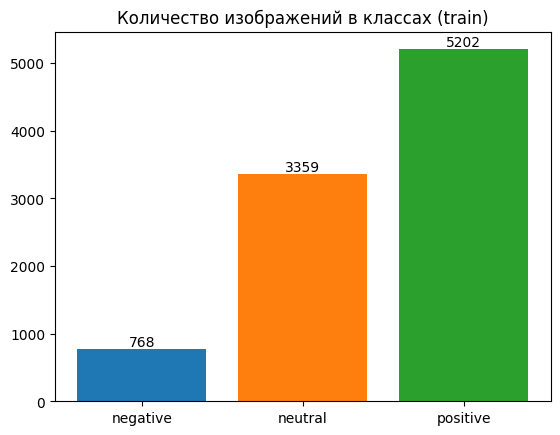

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (train)')
plt.show()

In [ ]:
unique, counts = np.unique(test_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 95, 417, 645]))

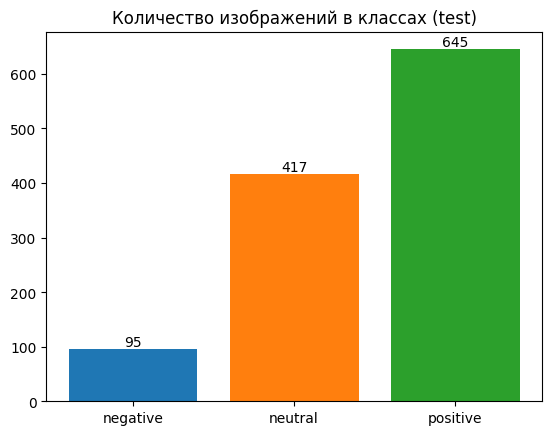

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (test)')
plt.show()

Так как в наборе существует дисбаланс классов, необходимо использовать веса, чтобы модель больше уделяла внимания тем классам, в которых мало объектов

In [ ]:
#Используем веса для классов в котором мало объектов
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_labels),
                                    y=train_labels)
class_weight = dict(enumerate(class_weight))
class_weight

{0: 4.049045138888889, 1: 0.9257715589957328, 2: 0.5977829040112778}

МОДЕЛИРОВАНИЕ


Для первой модели будем использовать 3 сверточных слоя с увеличением количества фильтров в два раза на каждом слое, также между ними будем использовать batch normalization слои для более быстрого обучения и слои max pooling для уменьшения изображения


In [ ]:
model1 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])

Воспользуемся чекпоинт коллбэком, чтобы во время обучения сохранить модель с наименьшей ошибкой


In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './model1.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

В качестве оптимизатора будет использоваться Nadam

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

#Обучение модели


In [ ]:
history = model1.fit(train_images, train_labels, epochs=20,
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=32, class_weight=class_weight, verbose=1)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2996 - loss: 2.8112
Epoch 1: val_loss improved from inf to 1.00130, saving model to ./model1.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.2996 - loss: 2.8072 - val_accuracy: 0.4641 - val_loss: 1.0013
Epoch 2/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5186 - loss: 0.9622
Epoch 2: val_loss did not improve from 1.00130
292/292 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.5191 - loss: 0.9620 - val_accuracy: 0.4235 - val_loss: 1.0081
Epoch 3/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6325 - loss: 0.8342
Epoch 3: val_loss improved from 1.00130 to 0.84995, saving model to ./model1.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.6326 - loss: 0.8342 - val_accuracy: 0.6154 - val_loss: 0.8499
Epoch 4/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6827 - loss: 0.7445
Epoch 4: val_loss did not improve from 0.84995
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/s

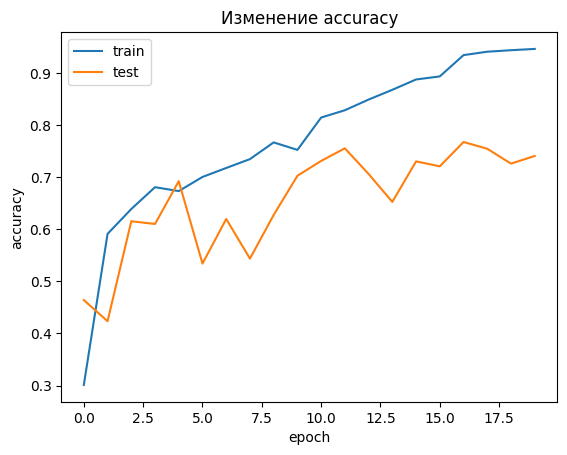

In [ ]:
#Выводим график точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

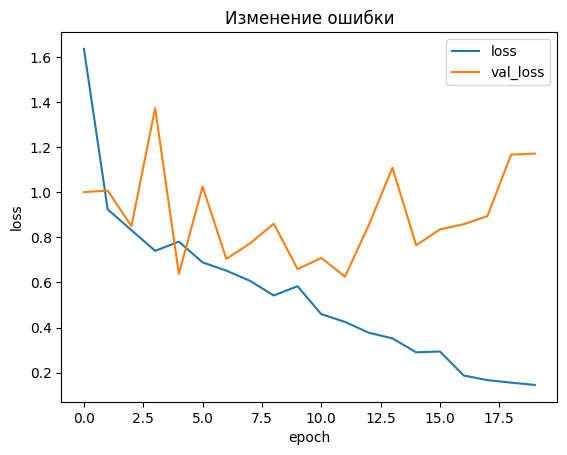

In [ ]:
#Визуализируем потери
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Модель сильно переобучилась, введем dropout слои, чтобы предотвратить сильное переобучение

In [ ]:
model2 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation='softmax'),
])

In [ ]:
#Создаём чекпоинт
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './model2.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

In [ ]:
#Добавляем оптимизатор
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

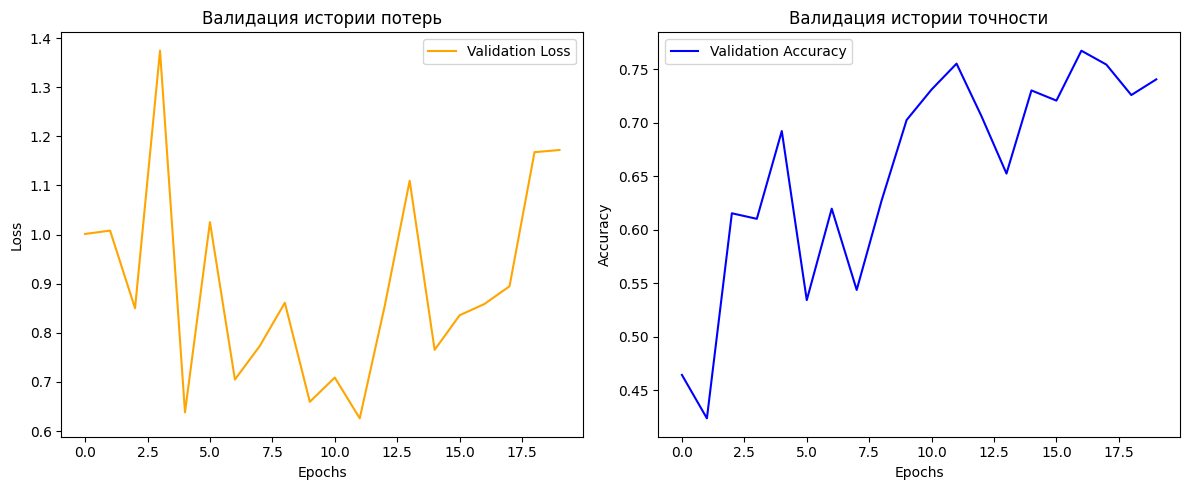

In [ ]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Валидация истории потерь')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Валидация истории точности')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Показать графики
plt.tight_layout()
plt.show()

In [ ]:
history = model2.fit(train_images, train_labels, epochs=20,
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=32, class_weight=class_weight, verbose=1)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1414 - loss: 2.3265
Epoch 1: val_loss improved from inf to 4.56548, saving model to ./model2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.1413 - loss: 2.3232 - val_accuracy: 0.1832 - val_loss: 4.5655
Epoch 2/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0966 - loss: 1.1256
Epoch 2: val_loss improved from 4.56548 to 1.41109, saving model to ./model2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.0967 - loss: 1.1256 - val_accuracy: 0.2351 - val_loss: 1.4111
Epoch 3/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0975 - loss: 1.1312
Epoch 3: val_loss did not improve from 1.41109
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.0976 - loss: 1.1310 - val_accuracy: 0.2143 - val_loss: 2.0321
Epoch 4/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1100 - loss: 1.1649
Epoch 4: val_loss improved from 1.41109 to 1.12451, saving model to ./model2.keras
292

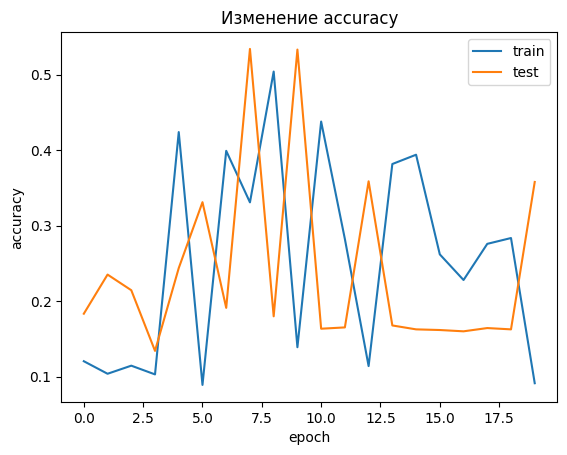

In [ ]:
#Смотрим изменение точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

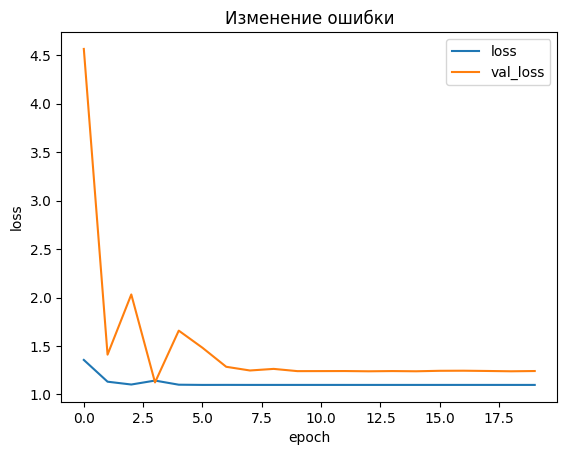

In [ ]:
#Смотрим изменение ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Модель оказалась слишком слабой и недообученной, попробуем другую архитектуру, между слоев max pooling будет по два сверточных слоя, между которыми будет batch normalization, количество фильтров не будет меняться, dropout будем использовать только между двух полносвязных слоев

In [ ]:
model3 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    # keras.layers.MaxPool2D(),
    # keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Conv2D(24, (3, 3), activation='relu'),
    # keras.layers.MaxPool2D(strides=2),
    # keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Conv2D(12, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((4, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax'),
])

In [ ]:
#Структура модели
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 247, 247, 20)        │             980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 247, 247, 20)        │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 245, 245, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 122, 122, 20)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 120, 120, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 120, 120, 20)        │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 118, 118, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 59, 59, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 57, 57, 20)          │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 57, 57, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 55, 55, 20)          │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 27, 27, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 20)          │           6,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 21, 21, 20)          │           6,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 96)                  │          48,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 80,627 (314.95 KB)

 Trainable params: 80,467 (314.32 KB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#Сохраняем модель во время обучения на гугл диск
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './drive/MyDrive/model3_11.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)


Также удвоим значение веса для самого минорного класса - лиц с негативным выражением

In [ ]:
model3_class_weight = class_weight.copy()
model3_class_weight[0] *= 2
history = model3.fit(train_images, train_labels, epochs=40, #70
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=128, class_weight=model3_class_weight, verbose=1)

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.2436 - loss: 1.7684
Epoch 1: val_loss improved from inf to 1.11198, saving model to ./drive/MyDrive/model3_11.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 87s 754ms/step - accuracy: 0.2431 - loss: 1.7655 - val_accuracy: 0.2826 - val_loss: 1.1120
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.2247 - loss: 1.3468
Epoch 2: val_loss improved from 1.11198 to 1.03408, saving model to ./drive/MyDrive/model3_11.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.2252 - loss: 1.3466 - val_accuracy: 0.5056 - val_loss: 1.0341
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3435 - loss: 1.2085
Epoch 3: val_loss improved from 1.03408 to 0.97234, saving model to ./drive/MyDrive/model3_11.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.3440 - loss: 1.2082 - val_accuracy: 0.5532 - val_loss: 0.9723
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4559 - loss: 1.1072
Epoch 

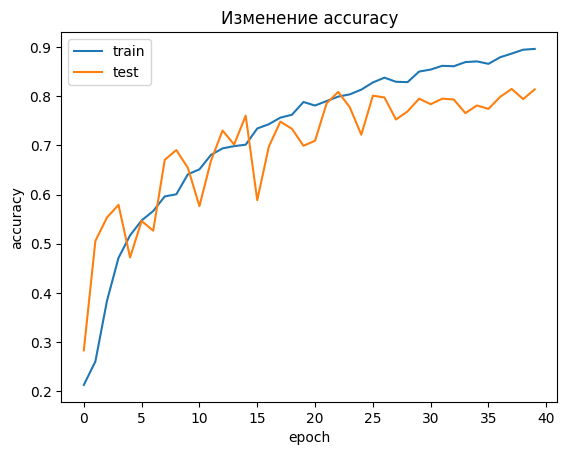

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

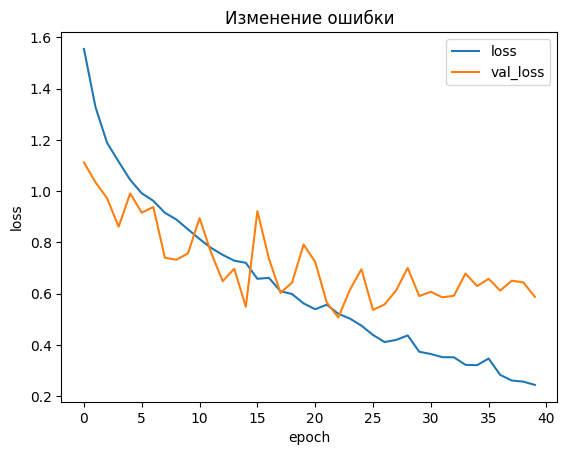

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Загрузка модели





In [ ]:
model = keras.models.load_model('./drive/MyDrive/model3_11.keras')

Оценка модели


In [ ]:
y_pred = [np.argmax(pred) for pred in model.predict(test_images)]

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


Выведем отчет классификации


In [ ]:
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43        95
           1       0.77      0.79      0.78       417
           2       0.90      0.87      0.88       645

    accuracy                           0.81      1157
   macro avg       0.70      0.70      0.70      1157
weighted avg       0.81      0.81      0.81      1157



Визуализируем матрицу ошибок


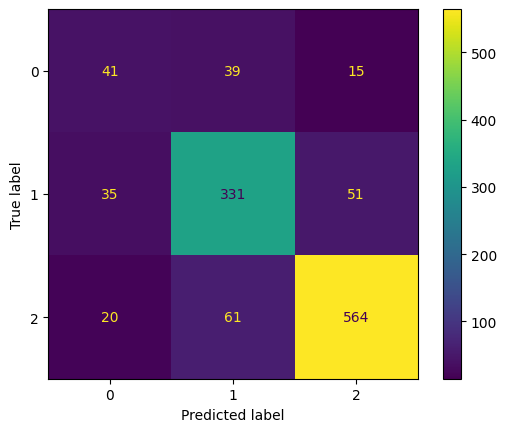

In [ ]:
cm = metrics.confusion_matrix(test_labels, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
cm_display.plot()
plt.show()

Выведем столбчатую диаграмму метрик f1, recall и precision

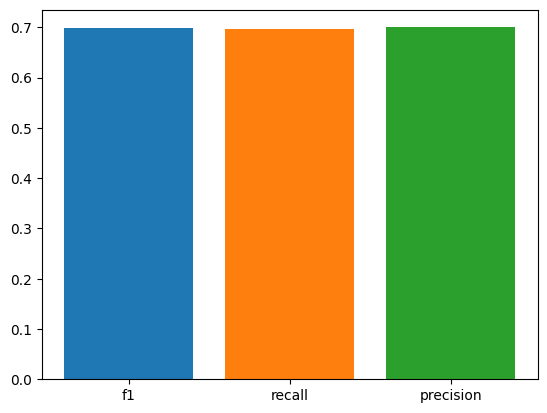

In [ ]:
plt.bar('f1', metrics.f1_score(y_pred, test_labels, average='macro'))
plt.bar('recall', metrics.recall_score(y_pred, test_labels, average='macro'))
plt.bar('precision', metrics.precision_score(y_pred, test_labels, average='macro'))
plt.show()

# Тестирование

In [ ]:
#Создадим функцию которая подстроит изображение под определённый формат
def prepare_image(image_path):
    img = cv2.imread(image_path)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(
        rgb_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )[0]
    x, y, w, h = face
    y1 = y - h // 3 if y - h // 2 >= 0 else 0
    y2 = y + h + h // 4
    x1 = x
    x2 = x + w
    print(x1, x2, y1, y2)
    if x2 - x1 < y2 - y1:
        z = -x2 + x1 + y2 - y1
        x2 += z // 2
        x1 -= z // 2
    print(z)

    cropped_img = rgb_img[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_img, (250, 250),
                               interpolation=cv2.INTER_LANCZOS4)
    return resized_image

251 833 0 860
278


array([[[208, 219, 224],
        [208, 219, 224],
        [208, 219, 224],
        ...,
        [220, 231, 233],
        [220, 231, 233],
        [220, 231, 233]],

       [[208, 219, 225],
        [208, 219, 225],
        [208, 219, 225],
        ...,
        [220, 231, 233],
        [220, 231, 233],
        [220, 231, 233]],

       [[209, 220, 226],
        [209, 220, 226],
        [209, 220, 226],
        ...,
        [220, 231, 233],
        [220, 231, 233],
        [220, 231, 233]],

       ...,

       [[244, 244, 244],
        [244, 244, 244],
        [244, 244, 244],
        ...,
        [249, 249, 249],
        [249, 249, 249],
        [249, 249, 249]],

       [[243, 244, 246],
        [243, 244, 246],
        [243, 244, 246],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [251, 251, 251]],

       [[236, 237, 241],
        [236, 237, 241],
        [237, 238, 242],
        ...,
        [251, 251, 251],
        [251, 251, 251],
        [251, 251, 251]]], dtype=uint8)
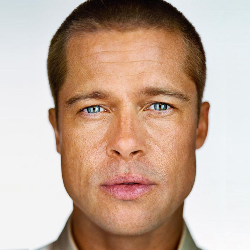

In [ ]:
img = prepare_image('/content/drive/MyDrive/face1.jfif')
img

In [ ]:
numbers_names[np.argmax(model.predict(np.array([img])))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'negative'

In [ ]:
model.predict(np.array([img]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[8.3973706e-01, 1.6026296e-01, 3.8511516e-08]], dtype=float32)

### Загрузка обученной модели

In [ ]:
import  torch
from torchvision import transforms
path_to_model_torch = './drive/MyDrive/diplom_emotions/models/torchscript_model_0_66_49_wo_gl.pth'
DICT_EMO = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}

In [ ]:
pth_model = torch.jit.load('/content/drive/MyDrive/torchscript_model_0_66_49_wo_gl.pth')

In [ ]:
def pth_model_predict(image, model=pth_model):
    output = torch.nn.functional.softmax(pth_model(image), dim=1).cpu().detach().numpy()
    return np.argmax(output)

In [ ]:
class PTHPipeLine:
    def __init__(self, model):
        self.model = model


    def pth_processing(self, fp):
        class PreprocessInput(torch.nn.Module):
            def init(self):
                super(PreprocessInput, self).init()

            def forward(self, x):
                x = x.to(torch.float32)
                x = torch.flip(x, dims=(0,))
                x[0, :, :] -= 91.4953
                x[1, :, :] -= 103.8827
                x[2, :, :] -= 131.0912
                return x

        def get_img_torch(img):
            img = img.resize((224, 224), Image.Resampling.NEAREST)
            ttransform = transforms.Compose([
                transforms.PILToTensor(),
                PreprocessInput()
            ])
            img = ttransform(img)
            img = torch.unsqueeze(img, 0)
            return img
        return get_img_torch(fp)


    def norm_coordinates(self, normalized_x, normalized_y, image_width, image_height):
        x_px = min(math.floor(normalized_x * image_width), image_width - 1)
        y_px = min(math.floor(normalized_y * image_height), image_height - 1)

        return x_px, y_px

    def get_box(self, fl, w, h):
        idx_to_coors = {}
        for idx, landmark in enumerate(fl.landmark):
            landmark_px = self.norm_coordinates(landmark.x, landmark.y, w, h)

            if landmark_px:
                idx_to_coors[idx] = landmark_px

        x_min = np.min(np.asarray(list(idx_to_coors.values()))[:,0])
        y_min = np.min(np.asarray(list(idx_to_coors.values()))[:,1])
        endX = np.max(np.asarray(list(idx_to_coors.values()))[:,0])
        endY = np.max(np.asarray(list(idx_to_coors.values()))[:,1])

        (startX, startY) = (max(0, x_min), max(0, y_min))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        return startX, startY, endX, endY
    def __call__(self, image_path = None, image=None):
        mp_face_mesh = mp.solutions.face_mesh
        with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=False,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        ) as face_mesh:
            if image_path:
                image = np.array(Image.open(image_path))
            results = face_mesh.process(image)
            if not results.multi_face_landmarks:
                return 0
            for fl in results.multi_face_landmarks:
                startX, startY, endX, endY  = self.get_box(fl, image.shape[1], image.shape[0])
                cur_face = image[startY:endY, startX: endX]
                cur_face = self.pth_processing(Image.fromarray(cur_face))

                output = torch.nn.functional.softmax(pth_model(cur_face), dim=1).cpu().detach().numpy()

                cl = np.argmax(output)
                return DICT_EMO[cl]


In [ ]:
pipe = PTHPipeLine(pth_model)

### Сравнение моделей

In [ ]:
#функция для разархивации датасета

In [ ]:
comparsion_images = []
comparsion_labels = []
for folder in ['positive', 'negative', 'neutral']:
    for image_path in os.listdir(f'/content/drive/MyDrive/test_img/{folder}'):
        image = Image.open(f'/content/drive/MyDrive/test_img/{folder}/{image_path}')
        comparsion_images.append(np.array(image)[:,:,:3])
        comparsion_labels.append(names_numbers[folder])
comparsion_images = np.array(comparsion_images, dtype='object')
comparsion_labels = np.array(comparsion_labels)

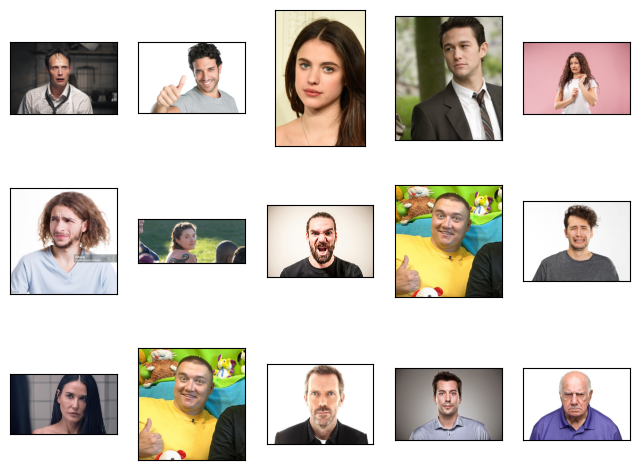

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(8, 6))
for i in range(15):
    ax = axs[i // 5, i % 5]
    ax.imshow(comparsion_images[random.randint(0, len(comparsion_images) - 1)])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
#Создаем словарь
convert_label_map = {'Surprise': 2, 'Happiness': 2, 'Neutral': 1, 'Anger': 0, 'Fear': 0, 'Disgust': 0, 'Sadness': 0}

In [ ]:
#Измерение времени
import time
start = time.time()
pth_labels = []
for image in comparsion_images:
    label = pipe(image=image)
    pth_labels.append(convert_label_map[label])
predict_time_pth = time.time() - start

In [ ]:
start = time.time()
tf_labels = []
for img in comparsion_images:
    img = prepare(img)
    tf_labels.append(np.argmax(model.predict(np.array([img]), verbose=0)))
predict_time_tf = time.time() - start

In [ ]:
print(metrics.classification_report(comparsion_labels, tf_labels))
print(metrics.classification_report(comparsion_labels, pth_labels))

              precision    recall  f1-score   support

           0       1.00      0.13      0.24        15
           1       0.43      0.82      0.56        11
           2       0.60      0.75      0.67        12

    accuracy                           0.53        38
   macro avg       0.68      0.57      0.49        38
weighted avg       0.71      0.53      0.47        38

              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.86      0.55      0.67        11
           2       0.91      0.83      0.87        12

    accuracy                           0.79        38
   macro avg       0.82      0.77      0.78        38
weighted avg       0.81      0.79      0.78        38

